## Классификация изображений
### Вводные слова
Задача классификации изображений - это одна из ключевых задач в области компьютерного зрения и машинного обучения. Она заключается в том, чтобы разработать модель, способную автоматически определить, к какому классу или категории принадлежит данное изображение. Классификация используется в следующих задачах: классификация спектрограмм музыкальных записей для выявления предпочтений конкретного пользователя, классификация изображений для автоматической идентификации людей на фотографиях, кластеризация покупок пользователя в интернет-магазине для формирования целевой рекламы, и так далее
### Рекомендации
Работу лучше выполнять в среде Google Colab, поскольку потребуется осуществлять вычисления на видеокарте. В Colab в меню нажмите на Изменить->Настройки блокнота и выберите доступный GPU. Это позволит использовать для обучения CUDA
### Цель работы и задачи
В данной работе мы разработаем модель, для предсказания класса на датасете cifar-10. Ниже будет представлена baseline модель, основываясь на которой вы можете строить свою модель для классификации
\
Задачи, которые вам нужно решить в работе:
\
Обязательные:
- Построить распределение классов в данных
- Подготовить данные и обучить baseline-модель на датасете
- Оценить качество модели
- Написать свою модель и обучить ее

Желательные:
- Подумать об архитектуре модели, быть может стоит сделать ее глубже, добавить боковые связи и т.д.
- Задуматься об аугментации
- Попробовать transfer-learning

\
\
Ваша работа будет оцениваться исходя из 2 факторов:
- контрольная метрика
- протокол исследования, которым и будет служить этот Jupyter-Notebook

\
Максимальный балл за работу - 20.
\
Удачи!

## Baseline-модель

In [1]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from torch.functional import F

Обучать мы будем, разумеется, на cuda, поэтому, создадим переменную device, которая будет зависеть от того, доступна ли видеокарта для вычислений

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Running on {device}')

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Running on cuda


In [3]:
class CustomCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
    
        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)    

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)

        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))  
        
        x = x.view(x.size(0), -1)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

Загрузим данные, построим диаграммы для распределения классов и посмотрим на сами картинки

Files already downloaded and verified
Files already downloaded and verified


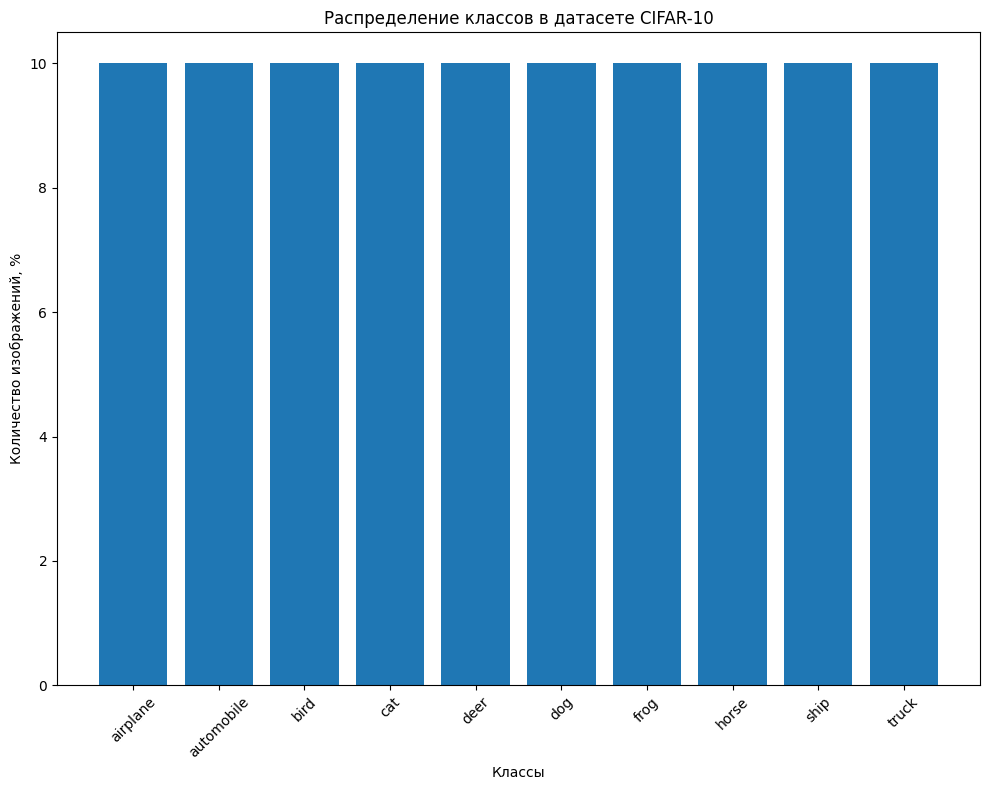

In [4]:
# Будем превращать картинку в torch.Tensor
transform = transforms.ToTensor()

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Трансформация для тестовых данных
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Загрузка датасетов
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform_train, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform_test, download=True)

# Получим метки классов
class_labels = train_dataset.classes
class_counts = np.array([0] * len(class_labels))

# Посчитаем число меток классов
for _, label in train_dataset:
    class_counts[label] += 1

class_counts = class_counts / class_counts.sum() * 100

# Построим диаграмму
plt.figure(figsize=(10, 8))
plt.bar(class_labels, class_counts)
plt.xlabel('Классы')
plt.ylabel('Количество изображений, %')
plt.title('Распределение классов в датасете CIFAR-10')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.5686275].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.58431375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.88235295].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.85882354].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.48235297].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.73333335].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the v

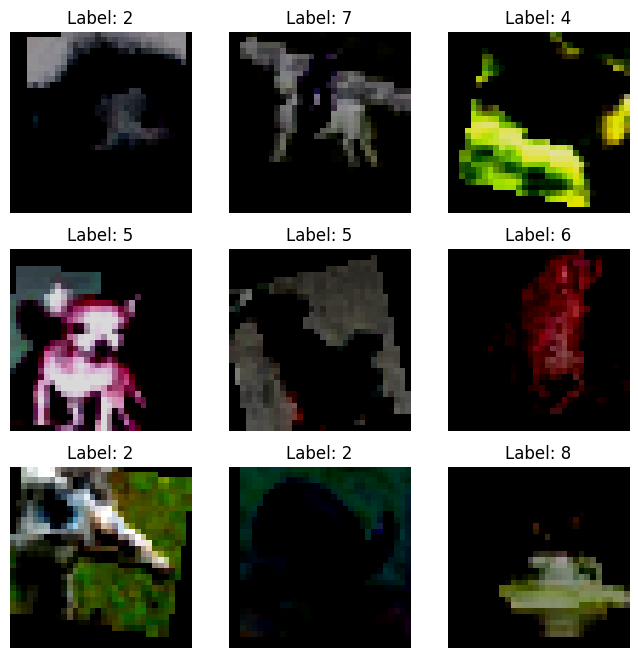

In [5]:
indices = np.random.choice(len(train_dataset), 9, replace=False)

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[indices[i]]
    image = image.numpy().transpose((1, 2, 0))  
    ax.imshow(image)
    ax.set_title(f'Label: {label}')
    ax.axis('off')

plt.show()

Сделайте вывод о сбалансированности датасета:
\
Исходя из этого, какие метрики будем применять для оценки качества модели?

Распределение: 
 - Все 10 классов (например, "airplane", "automobile", "bird" и т.д.) представлены равномерно, примерно по 10% от общего числа изображений.
 - Это говорит о том, что датасет сбалансирован, и проблема несбалансированности классов отсутствует.
 - Изображения имеют низкое разрешение (32x32 пикселя), что соответствует стандарту CIFAR-10. Это делает их анализ сложным для человеческого глаза, но подходящим для моделей глубокого обучения.
 - Некоторые изображения выглядят темными или странно окрашенными, что может быть связано с нормализацией данных (диапазон значений пикселей [-1, 1]). Для визуализации нормализацию нужно преобразовать в диапазон [0, 1] или [0, 255].
Метрики оценки:
 - Так как датасет сбалансирован, можно использовать accuracy (точность) в качестве основной метрики для оценки качества модели.
 - Дополнительно можно анализировать confusion matrix, чтобы увидеть, где модель делает ошибки (например, путает классы "cat" и "dog").

Напишем функции train и test

In [6]:
def train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=10):
    model.train()
    model = model.to(device)
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        pbar = tqdm(enumerate(train_loader), total=len(train_loader), ncols=100, desc=f'Train epoch {epoch + 1}/{epochs}')
        for batch_idx, (inputs, labels) in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            pbar.set_postfix({'loss': f'{running_loss / (batch_idx + 1):.4f}', 'accuracy': f'{correct / total:.4f}'})
        
        train_loss_history.append(running_loss / len(train_loader))
        train_acc_history.append(correct / total)

        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_loss_history.append(val_loss / len(val_loader))
        val_acc_history.append(val_correct / val_total)

        scheduler.step()

        print(f'Epoch {epoch + 1}/{epochs} -> Train Loss: {running_loss / len(train_loader):.4f}, Train Acc: {correct / total:.4f}, Val Loss: {val_loss / len(val_loader):.4f}, Val Acc: {val_correct / val_total:.4f}')
    
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

def test(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = test_loss / len(test_loader)
    
    return accuracy, average_loss

Сделайте разделение на train и val
\
Зачем так делать?

Разделение данных на train и test нужно, чтобы обучать модель на одной части данных (train) и проверять её качество на другой части (test), которую она не видела. Это помогает предотвратить переобучение и оценить способность модели обобщать закономерности на новых данных.

In [7]:
train_size = int(0.8 * len(train_dataset))  
val_size = len(train_dataset) - train_size  

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

Создайте Dataloader'ы и настройте гиперпараметры, оптимизатор и функцию потерь
\
Какой оптимизатор будете использовать и почему, а какую loss-функцию?

Оптимизатор: Adam
Выбран Adam из-за его адаптивного обучения. Он сочетает в себе преимущества Adagrad и RMSProp, динамически подстраивая скорость обучения для каждого параметра. Это делает его эффективным для задач классификации, особенно на сложных данных, таких как изображения.

Функция потерь: CrossEntropyLoss
Выбрана CrossEntropyLoss, так как она подходит для задач многоклассовой классификации. Она вычисляет разницу между предсказанным распределением вероятностей и истинным классом, эффективно обучая модель различать классы.

In [8]:
learning_rate = 0.001
num_epochs = 50
batch_size = 64

# Модель
model = CustomCNN(num_classes=10)
print('Model params: ', count_parameters(model))

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Планировщик обучения
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# DataLoader'ы
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Model params:  3064586


Обучите модель и постройте графики обучения

In [10]:
train_loss_history, train_acc_history, val_loss_history, val_acc_history = train(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=num_epochs)

Train epoch 1/50: 100%|█████████████| 625/625 [00:47<00:00, 13.24it/s, loss=0.9898, accuracy=0.6561]


Epoch 1/50 -> Train Loss: 0.9898, Train Acc: 0.6561, Val Loss: 0.6934, Val Acc: 0.7612


Train epoch 2/50: 100%|█████████████| 625/625 [00:49<00:00, 12.73it/s, loss=0.7932, accuracy=0.7232]


Epoch 2/50 -> Train Loss: 0.7932, Train Acc: 0.7232, Val Loss: 0.6560, Val Acc: 0.7774


Train epoch 3/50: 100%|█████████████| 625/625 [00:44<00:00, 13.98it/s, loss=0.7317, accuracy=0.7442]


Epoch 3/50 -> Train Loss: 0.7317, Train Acc: 0.7442, Val Loss: 0.6567, Val Acc: 0.7713


Train epoch 4/50: 100%|█████████████| 625/625 [00:45<00:00, 13.69it/s, loss=0.7056, accuracy=0.7542]


Epoch 4/50 -> Train Loss: 0.7056, Train Acc: 0.7542, Val Loss: 0.6106, Val Acc: 0.7882


Train epoch 5/50: 100%|█████████████| 625/625 [00:47<00:00, 13.13it/s, loss=0.6916, accuracy=0.7594]


Epoch 5/50 -> Train Loss: 0.6916, Train Acc: 0.7594, Val Loss: 0.6276, Val Acc: 0.7889


Train epoch 6/50: 100%|█████████████| 625/625 [00:45<00:00, 13.83it/s, loss=0.6675, accuracy=0.7670]


Epoch 6/50 -> Train Loss: 0.6675, Train Acc: 0.7670, Val Loss: 0.5960, Val Acc: 0.7945


Train epoch 7/50: 100%|█████████████| 625/625 [00:49<00:00, 12.65it/s, loss=0.6573, accuracy=0.7672]


Epoch 7/50 -> Train Loss: 0.6573, Train Acc: 0.7672, Val Loss: 0.5960, Val Acc: 0.7965


Train epoch 8/50: 100%|█████████████| 625/625 [00:47<00:00, 13.19it/s, loss=0.6460, accuracy=0.7736]


Epoch 8/50 -> Train Loss: 0.6460, Train Acc: 0.7736, Val Loss: 0.5675, Val Acc: 0.8057


Train epoch 9/50: 100%|█████████████| 625/625 [00:47<00:00, 13.16it/s, loss=0.6338, accuracy=0.7758]


Epoch 9/50 -> Train Loss: 0.6338, Train Acc: 0.7758, Val Loss: 0.5577, Val Acc: 0.8078


Train epoch 10/50: 100%|████████████| 625/625 [00:49<00:00, 12.71it/s, loss=0.6231, accuracy=0.7821]


Epoch 10/50 -> Train Loss: 0.6231, Train Acc: 0.7821, Val Loss: 0.5539, Val Acc: 0.8123


Train epoch 11/50: 100%|████████████| 625/625 [00:45<00:00, 13.69it/s, loss=0.5759, accuracy=0.7999]


Epoch 11/50 -> Train Loss: 0.5759, Train Acc: 0.7999, Val Loss: 0.5350, Val Acc: 0.8203


Train epoch 12/50: 100%|████████████| 625/625 [00:45<00:00, 13.89it/s, loss=0.5600, accuracy=0.8037]


Epoch 12/50 -> Train Loss: 0.5600, Train Acc: 0.8037, Val Loss: 0.5376, Val Acc: 0.8200


Train epoch 13/50: 100%|████████████| 625/625 [00:45<00:00, 13.65it/s, loss=0.5579, accuracy=0.8038]


Epoch 13/50 -> Train Loss: 0.5579, Train Acc: 0.8038, Val Loss: 0.5302, Val Acc: 0.8232


Train epoch 14/50: 100%|████████████| 625/625 [00:49<00:00, 12.60it/s, loss=0.5505, accuracy=0.8081]


Epoch 14/50 -> Train Loss: 0.5505, Train Acc: 0.8081, Val Loss: 0.5213, Val Acc: 0.8254


Train epoch 15/50: 100%|████████████| 625/625 [00:45<00:00, 13.77it/s, loss=0.5411, accuracy=0.8093]


Epoch 15/50 -> Train Loss: 0.5411, Train Acc: 0.8093, Val Loss: 0.5232, Val Acc: 0.8237


Train epoch 16/50: 100%|████████████| 625/625 [00:45<00:00, 13.82it/s, loss=0.5377, accuracy=0.8119]


Epoch 16/50 -> Train Loss: 0.5377, Train Acc: 0.8119, Val Loss: 0.5112, Val Acc: 0.8280


Train epoch 17/50: 100%|████████████| 625/625 [00:46<00:00, 13.45it/s, loss=0.5260, accuracy=0.8186]


Epoch 17/50 -> Train Loss: 0.5260, Train Acc: 0.8186, Val Loss: 0.5198, Val Acc: 0.8243


Train epoch 18/50: 100%|████████████| 625/625 [00:45<00:00, 13.79it/s, loss=0.5198, accuracy=0.8159]


Epoch 18/50 -> Train Loss: 0.5198, Train Acc: 0.8159, Val Loss: 0.5144, Val Acc: 0.8295


Train epoch 19/50: 100%|████████████| 625/625 [00:46<00:00, 13.40it/s, loss=0.5138, accuracy=0.8190]


Epoch 19/50 -> Train Loss: 0.5138, Train Acc: 0.8190, Val Loss: 0.4970, Val Acc: 0.8332


Train epoch 20/50: 100%|████████████| 625/625 [00:47<00:00, 13.06it/s, loss=0.5092, accuracy=0.8209]


Epoch 20/50 -> Train Loss: 0.5092, Train Acc: 0.8209, Val Loss: 0.5075, Val Acc: 0.8267


Train epoch 21/50: 100%|████████████| 625/625 [00:46<00:00, 13.43it/s, loss=0.4843, accuracy=0.8307]


Epoch 21/50 -> Train Loss: 0.4843, Train Acc: 0.8307, Val Loss: 0.4916, Val Acc: 0.8332


Train epoch 22/50: 100%|████████████| 625/625 [00:46<00:00, 13.41it/s, loss=0.4744, accuracy=0.8334]


Epoch 22/50 -> Train Loss: 0.4744, Train Acc: 0.8334, Val Loss: 0.4939, Val Acc: 0.8347


Train epoch 23/50: 100%|████████████| 625/625 [00:46<00:00, 13.34it/s, loss=0.4727, accuracy=0.8350]


Epoch 23/50 -> Train Loss: 0.4727, Train Acc: 0.8350, Val Loss: 0.4924, Val Acc: 0.8312


Train epoch 24/50: 100%|████████████| 625/625 [00:48<00:00, 12.82it/s, loss=0.4638, accuracy=0.8371]


Epoch 24/50 -> Train Loss: 0.4638, Train Acc: 0.8371, Val Loss: 0.4935, Val Acc: 0.8320


Train epoch 25/50: 100%|████████████| 625/625 [00:45<00:00, 13.65it/s, loss=0.4607, accuracy=0.8394]


Epoch 25/50 -> Train Loss: 0.4607, Train Acc: 0.8394, Val Loss: 0.4920, Val Acc: 0.8352


Train epoch 26/50: 100%|████████████| 625/625 [00:54<00:00, 11.48it/s, loss=0.4603, accuracy=0.8391]


Epoch 26/50 -> Train Loss: 0.4603, Train Acc: 0.8391, Val Loss: 0.4903, Val Acc: 0.8385


Train epoch 27/50: 100%|████████████| 625/625 [00:49<00:00, 12.66it/s, loss=0.4547, accuracy=0.8379]


Epoch 27/50 -> Train Loss: 0.4547, Train Acc: 0.8379, Val Loss: 0.4918, Val Acc: 0.8368


Train epoch 28/50: 100%|████████████| 625/625 [00:47<00:00, 13.13it/s, loss=0.4516, accuracy=0.8414]


Epoch 28/50 -> Train Loss: 0.4516, Train Acc: 0.8414, Val Loss: 0.4941, Val Acc: 0.8368


Train epoch 29/50: 100%|████████████| 625/625 [00:46<00:00, 13.49it/s, loss=0.4516, accuracy=0.8420]


Epoch 29/50 -> Train Loss: 0.4516, Train Acc: 0.8420, Val Loss: 0.4962, Val Acc: 0.8318


Train epoch 30/50: 100%|████████████| 625/625 [00:45<00:00, 13.69it/s, loss=0.4420, accuracy=0.8448]


Epoch 30/50 -> Train Loss: 0.4420, Train Acc: 0.8448, Val Loss: 0.4918, Val Acc: 0.8331


Train epoch 31/50: 100%|████████████| 625/625 [00:46<00:00, 13.58it/s, loss=0.4328, accuracy=0.8484]


Epoch 31/50 -> Train Loss: 0.4328, Train Acc: 0.8484, Val Loss: 0.4773, Val Acc: 0.8424


Train epoch 32/50: 100%|████████████| 625/625 [00:44<00:00, 14.04it/s, loss=0.4298, accuracy=0.8486]


Epoch 32/50 -> Train Loss: 0.4298, Train Acc: 0.8486, Val Loss: 0.4789, Val Acc: 0.8424


Train epoch 33/50: 100%|████████████| 625/625 [00:44<00:00, 14.19it/s, loss=0.4276, accuracy=0.8498]


Epoch 33/50 -> Train Loss: 0.4276, Train Acc: 0.8498, Val Loss: 0.4734, Val Acc: 0.8451


Train epoch 34/50: 100%|████████████| 625/625 [00:44<00:00, 14.16it/s, loss=0.4243, accuracy=0.8509]


Epoch 34/50 -> Train Loss: 0.4243, Train Acc: 0.8509, Val Loss: 0.4826, Val Acc: 0.8425


Train epoch 35/50: 100%|████████████| 625/625 [00:44<00:00, 14.16it/s, loss=0.4246, accuracy=0.8518]


Epoch 35/50 -> Train Loss: 0.4246, Train Acc: 0.8518, Val Loss: 0.4740, Val Acc: 0.8418


Train epoch 36/50: 100%|████████████| 625/625 [00:46<00:00, 13.51it/s, loss=0.4201, accuracy=0.8531]


Epoch 36/50 -> Train Loss: 0.4201, Train Acc: 0.8531, Val Loss: 0.4721, Val Acc: 0.8434


Train epoch 37/50: 100%|████████████| 625/625 [00:46<00:00, 13.41it/s, loss=0.4191, accuracy=0.8528]


Epoch 37/50 -> Train Loss: 0.4191, Train Acc: 0.8528, Val Loss: 0.4766, Val Acc: 0.8414


Train epoch 38/50: 100%|████████████| 625/625 [00:46<00:00, 13.54it/s, loss=0.4166, accuracy=0.8528]


Epoch 38/50 -> Train Loss: 0.4166, Train Acc: 0.8528, Val Loss: 0.4749, Val Acc: 0.8422


Train epoch 39/50: 100%|████████████| 625/625 [00:45<00:00, 13.72it/s, loss=0.4183, accuracy=0.8532]


Epoch 39/50 -> Train Loss: 0.4183, Train Acc: 0.8532, Val Loss: 0.4723, Val Acc: 0.8454


Train epoch 40/50: 100%|████████████| 625/625 [00:45<00:00, 13.79it/s, loss=0.4169, accuracy=0.8533]


Epoch 40/50 -> Train Loss: 0.4169, Train Acc: 0.8533, Val Loss: 0.4711, Val Acc: 0.8443


Train epoch 41/50: 100%|████████████| 625/625 [00:45<00:00, 13.74it/s, loss=0.4038, accuracy=0.8589]


Epoch 41/50 -> Train Loss: 0.4038, Train Acc: 0.8589, Val Loss: 0.4712, Val Acc: 0.8465


Train epoch 42/50: 100%|████████████| 625/625 [00:46<00:00, 13.50it/s, loss=0.4032, accuracy=0.8589]


Epoch 42/50 -> Train Loss: 0.4032, Train Acc: 0.8589, Val Loss: 0.4711, Val Acc: 0.8448


Train epoch 43/50: 100%|████████████| 625/625 [00:46<00:00, 13.40it/s, loss=0.4061, accuracy=0.8589]


Epoch 43/50 -> Train Loss: 0.4061, Train Acc: 0.8589, Val Loss: 0.4672, Val Acc: 0.8471


Train epoch 44/50: 100%|████████████| 625/625 [00:46<00:00, 13.53it/s, loss=0.4061, accuracy=0.8558]


Epoch 44/50 -> Train Loss: 0.4061, Train Acc: 0.8558, Val Loss: 0.4653, Val Acc: 0.8477


Train epoch 45/50: 100%|████████████| 625/625 [00:45<00:00, 13.79it/s, loss=0.3991, accuracy=0.8591]


Epoch 45/50 -> Train Loss: 0.3991, Train Acc: 0.8591, Val Loss: 0.4686, Val Acc: 0.8476


Train epoch 46/50: 100%|████████████| 625/625 [00:43<00:00, 14.22it/s, loss=0.4019, accuracy=0.8578]


Epoch 46/50 -> Train Loss: 0.4019, Train Acc: 0.8578, Val Loss: 0.4694, Val Acc: 0.8480


Train epoch 47/50: 100%|████████████| 625/625 [00:44<00:00, 14.20it/s, loss=0.4005, accuracy=0.8586]


Epoch 47/50 -> Train Loss: 0.4005, Train Acc: 0.8586, Val Loss: 0.4668, Val Acc: 0.8481


Train epoch 48/50: 100%|████████████| 625/625 [00:47<00:00, 13.12it/s, loss=0.4014, accuracy=0.8601]


Epoch 48/50 -> Train Loss: 0.4014, Train Acc: 0.8601, Val Loss: 0.4660, Val Acc: 0.8489


Train epoch 49/50: 100%|████████████| 625/625 [00:51<00:00, 12.19it/s, loss=0.3938, accuracy=0.8611]


Epoch 49/50 -> Train Loss: 0.3938, Train Acc: 0.8611, Val Loss: 0.4706, Val Acc: 0.8469


Train epoch 50/50: 100%|████████████| 625/625 [00:53<00:00, 11.68it/s, loss=0.3964, accuracy=0.8608]


Epoch 50/50 -> Train Loss: 0.3964, Train Acc: 0.8608, Val Loss: 0.4699, Val Acc: 0.8479


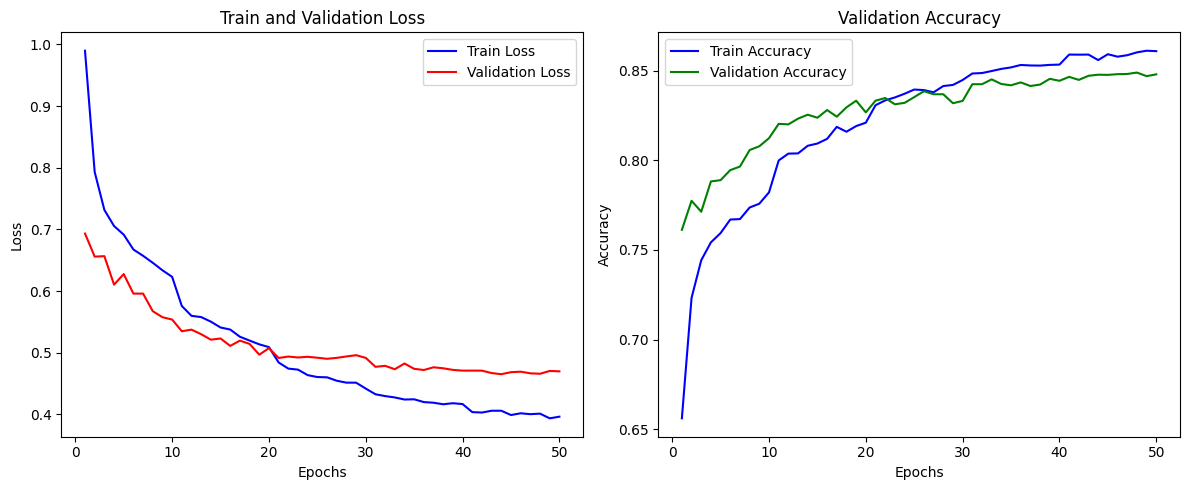

In [11]:
epochs = range(1, len(train_loss_history) + 1)

# График функции потерь на тренировочных данных
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b', label='Train Loss')
plt.plot(epochs, val_loss_history, 'r', label='Validation Loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности на валидационных данных
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b', label='Train Accuracy')
plt.plot(epochs, val_acc_history, 'g', label='Validation Accuracy')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Сделайте выводы о качестве обучения

Train и Validation Loss (слева):
 - Убывание функции потерь как для обучающей, так и для валидационной выборок говорит о том, что модель успешно обучается.
 - Кривая валидационной функции потерь стабилизируется после 30 эпох, что указывает на отсутствие переобучения.

Train и Validation Accuracy (справа):
 - Точность на обучающей выборке плавно возрастает, достигая около 85%.
 - Точность на валидационной выборке также улучшается и сопоставима с обучающей, что подтверждает хорошую обобщающую способность модели.

Оцените тестовую метрику на тестовых данных

In [12]:
test_acc, test_loss = test(model, test_loader, criterion, device)
print('Test Loss: {:.4f}\nTest Accuracy: {:.4f}'.format(test_loss, test_acc))

Test Loss: 0.4699
Test Accuracy: 0.8479


## Что дальше?
Теперь, когда у вас есть все необходимое - экспериментируйте. Можете изменить все что угодно, креативность поощряется. Используйте новые модели, loss-функции, аугментацию, ансамбли, выдумывайте все, что сможете

## Критерии оценки
Accuracy - на тестовых данных
- $Accuracy \leq 0.67$ - 0 баллов
- $0.67 < Accuracy \leq 0.72$ - 2 балла
- $0.72 < Accuracy \leq 0.77$ - 4 балла
- $0.77 < Accuracy \leq 0.82$ - 6 баллов
- $0.82 < Accuracy \leq 0.87$ - 8 баллов
- $Accuracy > 0.87$ - 10 баллов